# Single Image Deep Steganography

In [1]:
import random
import os
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import tensorflow as tf
import keras.backend as K
import keras.utils

from src.TinyDataset import TinyImageDataset
from src.StegModels import CNNModels
from src.LossFunctions import LossFunctions
from src.PickleTools import PickleTools as pt

# Training Environment and Model Parameters

In [2]:
# Random Seed
keras.utils.set_random_seed(42)

# TF 1.0 Graph for faster training.
graph = tf.Graph()

# Dataset Location
train_path = os.path.join("src/Datasets/tiny-imagenet-200/", "train")

# Secret Cover Loss function: beta = 0.25 (best results)
betas = [0.25, 0.5, 0.75, 1.0]
loss = LossFunctions()
loss.single_beta = 0.25
beta = betas[0]

# Model Parameters
activation_functions = ["relu", "selu", "gelu", "swish"]
activation = activation_functions[0]
filters_shape = (50, 20, 10)
epochs = 2
batch_size = 32

# Wrapper Function to call Model Training
* CNN Models Stored in StegModels.
* batch_size, epochs - self explanatory.
* save_path - Path to save models too, if path does not exist it will create one at the desired location.
* save_interval - Epoch interval to save weights.
* filter1-3 - number of filters to use in the CNN layers, 3 layers 3 filter arguments.
* secret/cov_input - secret and cover images to train on.

# Returns encoder, decoder and autoencoder keras model objects.

In [3]:
def process(batch_size, epochs, save_path, save_interval, activation, filter1, filter2, filter3, verbose, secret_input_input, cov_input):

        cnn_model = CNNModels()
        input_shape = secret_input_input.shape[1:]

        start_time = time.time()
        encoder_model, decoder_model, autoencoder_model = cnn_model.train_one_secret(
            batch_size=batch_size,
            epochs=epochs,
            path=save_path,
            shape=input_shape,
            reveal_loss=loss.reveal_loss,
            full_loss=loss.full_loss,
            secret_input=secret_input_input,
            cover_input=cov_input,
            verbose=verbose,
            save_interval=save_interval,
            activation=activation,
            filter1=filter1,
            filter2=filter2,
            filter3=filter3
        )
        end_time = round(time.time() - start_time)

        if end_time > 60:
            end_time = end_time / 60
            print(f"Model Finished Training in: {end_time} m")
        else:
            print(f"Model Finished Training in: {end_time} s")

        return encoder_model, decoder_model, autoencoder_model

In [1]:
# Function to calculate the Mean Sum of Squared Errors Per Pixel
def pixel_error_outputs(input_secret, input_cover, decoded_secret, decoded_cover_image):
        # Mean sum of squared errors per pixel
        decoded_secret_errors = np.sqrt(np.mean(np.square(255 * (input_secret - decoded_secret))))
        embedded_cover_errors = np.sqrt(np.mean(np.square(255 * (input_cover - decoded_cover_image))))
        return decoded_secret_errors, embedded_cover_errors

In [4]:
def train_model(epochs, activation_function, batch_size, filters, _beta):
    total_filters = sum(list(filters))
    f1 = filters[0]
    f2 = filters[1]
    f3 = filters[2]

    save_path = f"src/Image Models/Testing Results/{total_filters}F_{batch_size}BS_{epochs}EP_{activation_function}_BETA{_beta}/"
    dataset_local = TinyImageDataset(path=train_path, num_classes=25, normalize=True)
    X_train_local = dataset_local.load_data()
    secret_input_local = X_train_local[0:2500]
    cov_input_local = X_train_local[2500:5000]

    encoder_model, decoder_model, autoencoder_model = process(
        batch_size=batch_size,
        epochs=epochs,
        save_path=save_path,
        save_interval=1,
        activation=activation_function,
        filter1=f1,
        filter2=f2,
        filter3=f3,
        verbose=1,
        secret_input_input=secret_input_local,
        cov_input=cov_input_local
    )

    def run_loss_history():
        loss_history = pt(save_path, "loss_history.pckl", "rb").load()

        plt.plot(loss_history)
        plt.title(f'Loss Curve For: 1X: {total_filters}F_{batch_size}BS_{epochs}EP_{activation_function}_{_beta}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

        epoch_patch = mpatches.Patch(color='blue', label=f'Total Epochs: {epochs}')
        beta_patch = mpatches.Patch(color='blue', label=f'Total Epochs: {_beta}')
        batch_patch = mpatches.Patch(color='blue', label=f'Batch Size: {batch_size}')
        act_patch = mpatches.Patch(color='blue', label=f'Activation Function: {activation_function}')
        plt.legend(handles=[beta_patch, epoch_patch, batch_patch, act_patch], loc="upper right")

        plt.savefig(f"{save_path}loss.png")
        plt.figure().clear()
        plt.close()

    run_loss_history()

    decoded = autoencoder_model.predict([secret_input_local, cov_input_local])
    decoded_secret, decoded_cover = decoded[..., 0:3], decoded[..., 3:6]



    S1_error_outputs, C_error_outputs = pixel_error_outputs(secret_input_local, cov_input_local, decoded_secret, decoded_cover)
    decoded_secret_pixel_diff, embedded_cover_diff = np.abs(decoded_secret - secret_input_local), np.abs(decoded_cover - cov_input_local)

    def show_image_results():
        num_imgs = 4
        random_index = [random.randint(0, 375) for _ in range(num_imgs)]
        plt.figure(figsize=(11, 12))

        def show_image(img, n_rows, num_col, index, title_row=False, title=None):
            ax = plt.subplot(n_rows, num_col, index)
            plt.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if title_row:
                plt.title(title)

        for i, idx in enumerate(random_index):
            n_col = 8

            show_image(cov_input_local[idx], num_imgs, n_col, i * n_col + 1, title_row=i == 0, title='Cover')

            show_image(secret_input_local[idx], num_imgs, n_col, i * n_col + 2, title_row=i == 0, title='Secret1')

            show_image(decoded_cover[idx], num_imgs, n_col, i * n_col + 5, title_row=i == 0, title='Cover*')

            show_image(decoded_secret[idx], num_imgs, n_col, i * n_col + 6, title_row=i == 0, title='Decoded1')

        plt.savefig(f"{save_path}image_comparison.png")
        plt.figure().clear()
        plt.close()

    show_image_results()

    pt(save_path, "decoded_secret.pckl", decoded_secret).save()
    pt(save_path, "decoded_cover.pckl", decoded_cover).save()
    pt(save_path, "secret1_diff.pckl", decoded_secret_pixel_diff).save()
    pt(save_path, "cover_diff.pckl", embedded_cover_diff).save()
    pt(save_path, "secret1_pixel_error_outputs.pckl", S1_error_outputs).save()
    pt(save_path, "cover_pixel_error_outputs.pckl", C_error_outputs).save()

    print(f"Model Saved at: {save_path}")

    print("Error per pixel - distance from original RGB")
    print(f"S1 Pixel error_outputs: {S1_error_outputs}")
    print(f"C Pixel error_outputs: {C_error_outputs}")


Epoch 0


C:\Users\Jacob\Documents\GitHub\JH-Deep-Steganography\venv\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Epoch 1
Model Finished Training in: 57 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model Saved at: model-data/80F_32BS_2EP_relu_BETA0.25/
Error per pixel - distance from original RGB
S1 Pixel error_outputs: 40.77021408081055
C Pixel error_outputs: 26.352413177490234


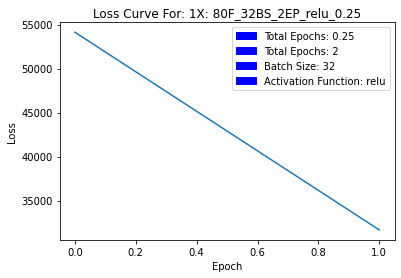

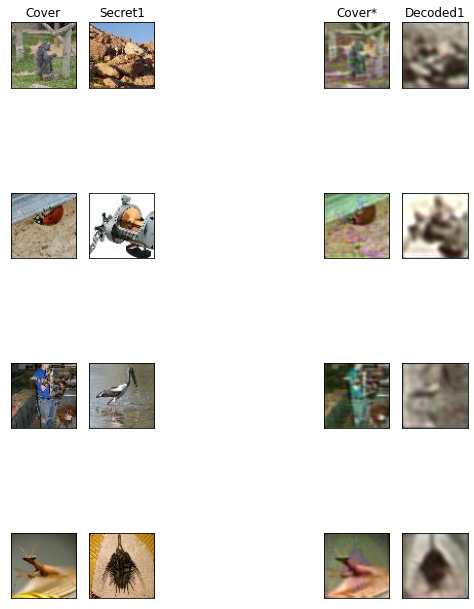

In [5]:
with tf.device('gpu:0'):
    with graph.as_default():
        train_model(epochs=epochs, activation_function=activation, batch_size=batch_size, filters=filters_shape, _beta=beta)